In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(5):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Please see also my comment on Die Nibelungen part 1: Siegfried.<br /><br />The second part of UFA studio's gargantuan production of the Nibelungen saga continues in the stylised, symphonic and emotionally detached manner of its predecessor. However, whereas part one was a passionless portrayal of individual acts of heroism, part two is a chaotic depiction of bloodletting on a grand scale.<br /><br />As in part one, director Fritz Lang maintains a continuous dynamic rhythm, with the pace of the action and the complexity of the shot composition rising and falling smoothly as the tone of each scene demands. These pictures should only be watched with the note-perfect Gottfried Huppertz score, which fortunately is on the Kino DVD. Now, with this focus on mass action, Lang is presented with greater challenges in staging. The action sequences in his earliest features were often badly constructed, but now he simply makes them part of that rhythmic flow, with the level of activity on

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[583,  68,  79, ...,   0,   0,   0],
       [308,  15,   2, ...,   0,   0,   0],
       [ 11,  18,  14, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Please see also my comment on Die Nibelungen part 1: Siegfried.<br /><br />The second part of UFA studio's gargantuan production of the Nibelungen saga continues in the stylised, symphonic and emotionally detached manner of its predecessor. However, whereas part one was a passionless portrayal of individual acts of heroism, part two is a chaotic depiction of bloodletting on a grand scale.<br /><br />As in part one, director Fritz Lang maintains a continuous dynamic rhythm, with the pace of the action and the complexity of the shot composition rising and falling smoothly as the tone of each scene demands. These pictures should only be watched with the note-perfect Gottfried Huppertz score, which fortunately is on the Kino DVD. Now, with this focus on mass action, Lang is presented with greater challenges in staging. The action sequences in his earliest features were often badly constructed, but now he simply makes them part of that rhythmic flow, with the level of activity 

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.00650911]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 1s 744ms/step
[0.00650911]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 676s 2s/step - loss: 0.2963 - accuracy: 0.8741 - val_loss: 0.3196 - val_accuracy: 0.8589
Epoch 2/10
391/391 [==============================] - 645s 2s/step - loss: 0.2937 - accuracy: 0.8757 - val_loss: 0.3411 - val_accuracy: 0.8464
Epoch 3/10
391/391 [==============================] - 649s 2s/step - loss: 0.2929 - accuracy: 0.8764 - val_loss: 0.3337 - val_accuracy: 0.8536
Epoch 4/10
391/391 [==============================] - 647s 2s/step - loss: 0.2908 - accuracy: 0.8758 - val_loss: 0.3157 - val_accuracy: 0.8594
Epoch 5/10
391/391 [==============================] - 653s 2s/step - loss: 0.2907 - accuracy: 0.8760 - val_loss: 0.3148 - val_accuracy: 0.8604
Epoch 6/10
391/391 [==============================] - 640s 2s/step - loss: 0.2883 - accuracy: 0.8768 - val_loss: 0.3225 - val_accuracy: 0.8646
Epoch 7/10
391/391 [==============================] - 644s 2s/step - loss: 0.2886 - accuracy: 0.8780 - val_loss: 0.3134 - val_accuracy: 0.8609

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 169s 432ms/step - loss: 0.3157 - accuracy: 0.8550
Test Loss: 0.31569916009902954
Test Accuracy: 0.8550000190734863


(0.0, 0.34409996271133425)

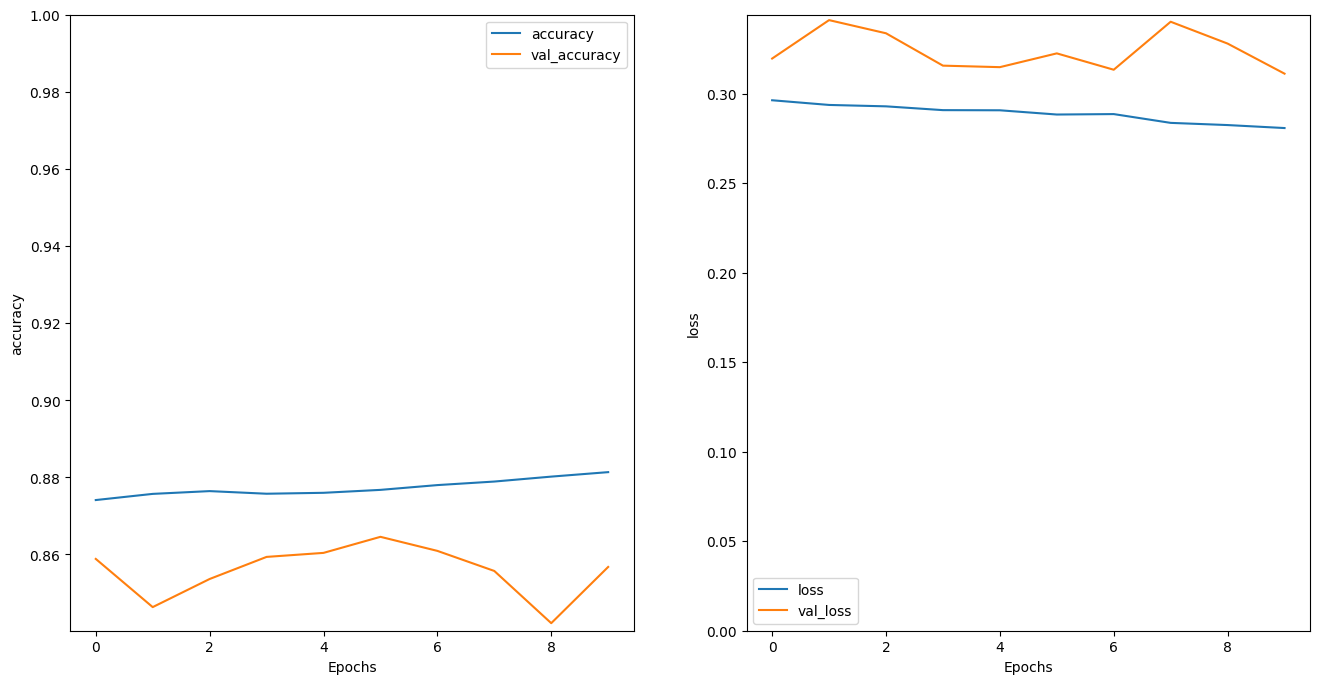

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 5s 5s/step


In [ ]:
predictions

array([[0.4951532]], dtype=float32)

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)